In [1]:
from GWAPWAi import *
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
observ_dict = reorganize_instructions(parse_file("test_input.in"))
flat_params, unpack_fn, static_params = pack_parameters(observ_dict, wave="P")
static_params["channel_names"] = observ_dict["channels"]["names"]
exp_data = load_data(observ_dict)

In [4]:
sqrt_s_grid, values, errors, masks, channel_list, model_channel_indices = prepare_data(exp_data, static_params)
s_vals_c = (sqrt_s_grid ** 2).to(dtype=torch.cdouble)

weight_vector = torch.tensor([
    observ_dict["fitting"]["InclChi2Weight"][0] if ch == "inclusive"
    else observ_dict["fitting"]["ExclChi2Weight"][0]
    for ch in channel_list
], dtype=torch.float64, device=flat_params.device)

In [5]:

#move everything to device and precompute the integral (THIS IS THE ONLY EXPENSIVE CELL)
for k, v in static_params.items():
    if isinstance(v, torch.Tensor):
        static_params[k] = v.to(device)
II = precompute_II(
    s_vals_c,
    static_params,
    integrate_rhoN_scp,
    rhoN_dispatcher,
    momentum,
    sheet = 0, #dont have implemented other than 0
    epsilon = 0.001,
    num_integ = 100
).to(device)

flat_params = randomize_initial_params(observ_dict, unpack_fn, wave="P").to(device)

/Users/wyatt/Development/GWAi-PWA/GWAPWAi/amplitude.py:256: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_int, imag_err = quad(lambda t: np.imag(integrand(t)),
/Users/wyatt/Development/GWAi-PWA/GWAPWAi/amplitude.py:256: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  imag_int, imag_err = quad(lambda t: np.imag(integrand(t)),


In [6]:
model = ChiSquaredLossModule(
    initial_params=flat_params,
    unpack_fn=unpack_fn,
    static_params=static_params,
    s_vals_c=s_vals_c,
    II=II,
    values=values.to(flat_params.device),
    errors=errors.to(flat_params.device),
    masks=masks.to(flat_params.device),
    model_channel_indices=model_channel_indices.to(flat_params.device),
    weight_vector=weight_vector.to(flat_params.device),
    compute_intensity_func=compute_intensity,
    numerator_func=numerator,
    omega_pole_func=omega_pole,
    construct_phsp_func=construct_phsp,
    K_nominal_func=K_nominal,
    momentum_func=momentum
).to(device)

In [7]:
best_fit_params = run_fit(model, initial_params=flat_params, num_starts=100, adam_iters=50, lbfgs_iters=300, adam_lr=1e-2)


=== Start 1/100 ===
[Adam iter   0] χ² = 818733753.7011, max |grad| = 2.6622e+10
Final χ² after LBFGS: 78785.0486

=== Start 2/100 ===
[Adam iter   0] χ² = 50390318.2184, max |grad| = 1.2568e+08
Final χ² after LBFGS: 57550.2157

=== Start 3/100 ===
[Adam iter   0] χ² = 414115979.5833, max |grad| = 3.5258e+09
Final χ² after LBFGS: 87459.7878

=== Start 4/100 ===
[Adam iter   0] χ² = 12181870845.6323, max |grad| = 4.7076e+12
Final χ² after LBFGS: 52595.3609

=== Start 5/100 ===
[Adam iter   0] χ² = 424605358.3157, max |grad| = 2.8173e+10
Final χ² after LBFGS: 56857.7375

=== Start 6/100 ===
[Adam iter   0] χ² = 3207906182.0264, max |grad| = 9.4377e+11
Final χ² after LBFGS: 60696.8558

=== Start 7/100 ===
[Adam iter   0] χ² = 478236539.3242, max |grad| = 3.4088e+09
Final χ² after LBFGS: 54473.1941

=== Start 8/100 ===
[Adam iter   0] χ² = 55642060.5165, max |grad| = 1.5285e+08
Final χ² after LBFGS: 56116.7491

=== Start 9/100 ===
[Adam iter   0] χ² = 1675913772.7800, max |grad| = 2.1050e

Total χ² (summed across all data channels): 20456.87


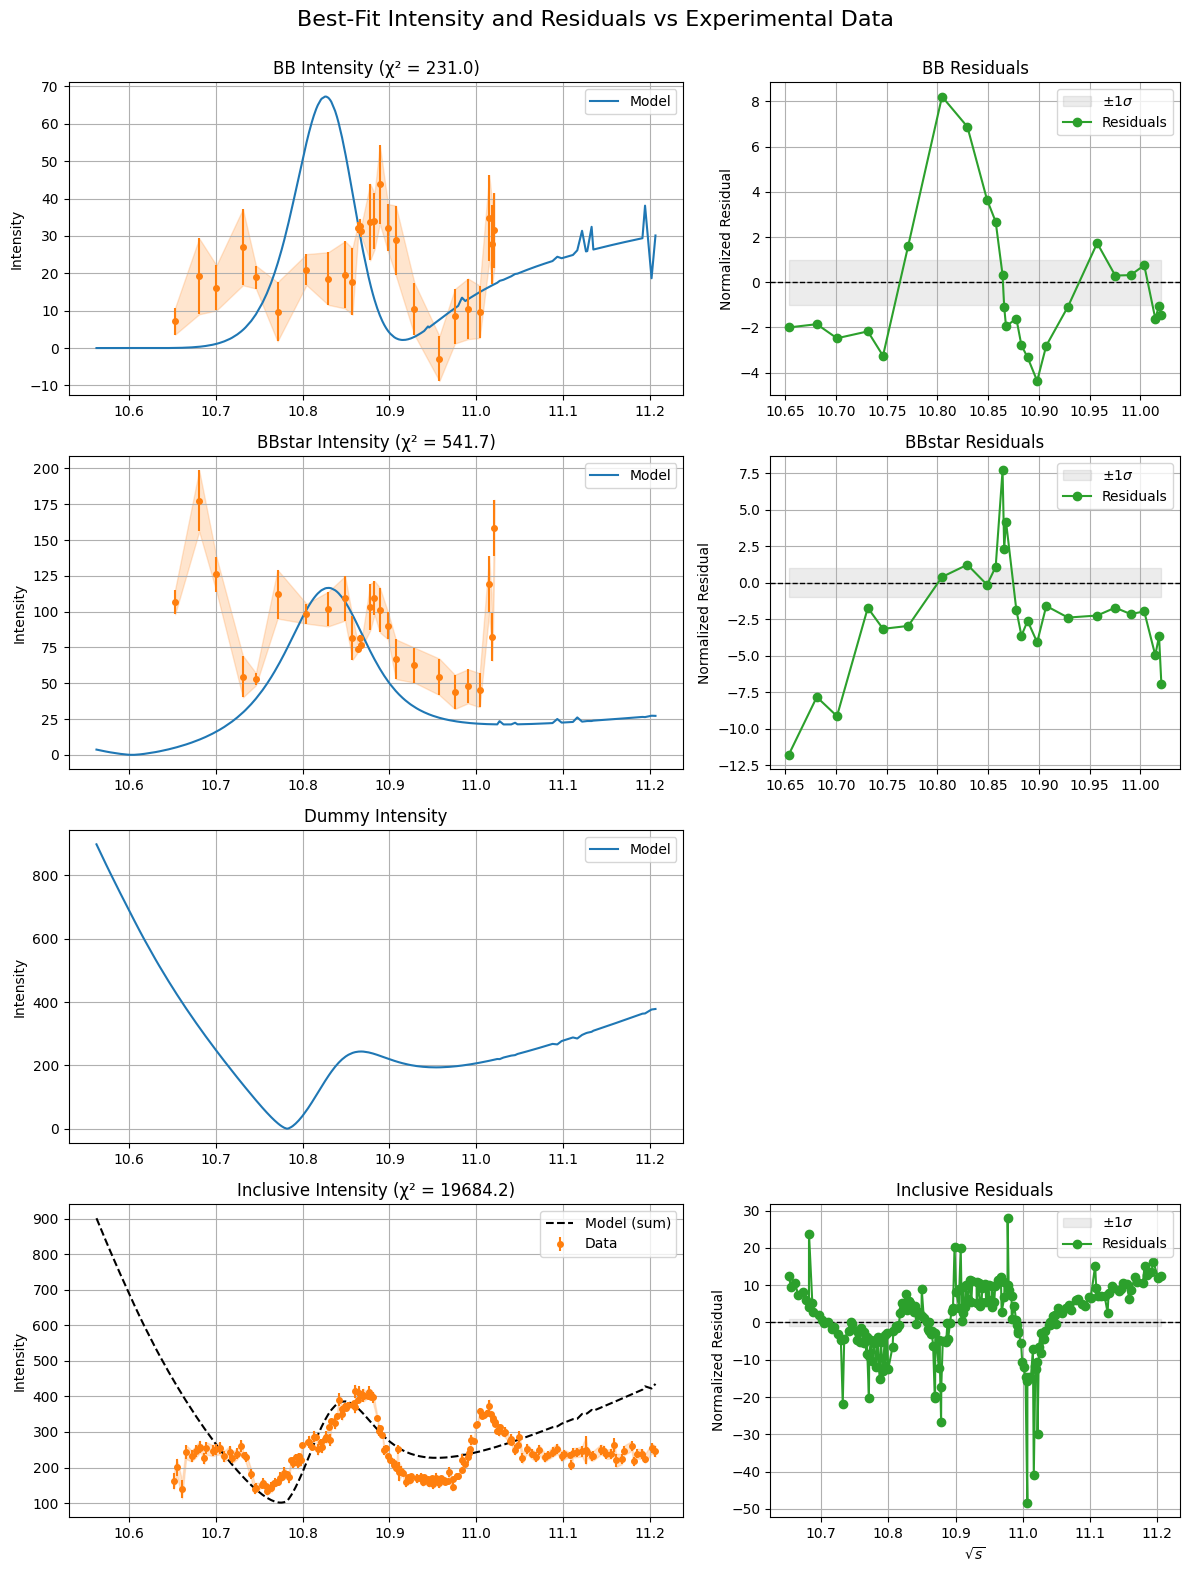

In [8]:
plot_fit_vs_data_full(
    best_fit_params=best_fit_params,
    model=model,
    sqrt_s_grid=sqrt_s_grid,
    values=values,
    errors=errors,
    masks=masks,
    channel_list=channel_list  # from prepare_exp_s_grid_and_data
)


In [10]:
updated_observ_dict = update_dict(
    observ_dict=observ_dict,
    wave="P",
    flat_params=best_fit_params,
    unpack_fn=unpack_fn
)
updated_observ_dict

{'channels': {'names': ['BB', 'BBstar', 'Dummy'],
  'masses': tensor([[5.2793, 5.2793],
          [5.2793, 5.3247],
          [5.3669, 5.4154]], dtype=torch.float64)},
 'waves': ['P'],
 'wave_data': {'P': {'kmat_type': 'kmat-nominal',
   'rhoN_type': 'rhoN-nominal',
   'J': 1,
   'sL': -81.0,
   'ChebyCoeffs': {'s': ['s = 1', 's = 1', 's = 1'],
    'coeffs': tensor([[ -7.9056, -41.6183,  37.1045],
            [-23.3716, -42.5004,  50.8825],
            [-18.0592, -25.9992, -23.0726]], dtype=torch.float64),
    'errors': tensor([[20., 20., 20.],
            [20., 20., 20.],
            [20., 20., 20.]], dtype=torch.float64)},
   'Poles': {'mass': tensor([ 86.1542, 120.5749], dtype=torch.float64),
    'mass_err': tensor([5., 5.]),
    'couplings': tensor([[ 112.1975,   52.8835],
            [   7.5813,   -0.5427],
            [-109.0227,   37.6912]], dtype=torch.float64),
    'coupling_err': tensor([[20., 20.],
            [20., 20.],
            [20., 20.]], dtype=torch.float64)},
   'K